# Face Recognition 

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from skimage import color
import glob
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import imghdr

C:\Users\kimh1\AppData\Local\Temp\ipykernel_21880\1949740308.py:12: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Load Folder

In [2]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [3]:
print("Shape of images:", dataset['data'].shape)
print("Shape of labels:", dataset['target'].shape)
print("Unique labels:", dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


## Data Visualization

### Image Distribuition of Top 20 People

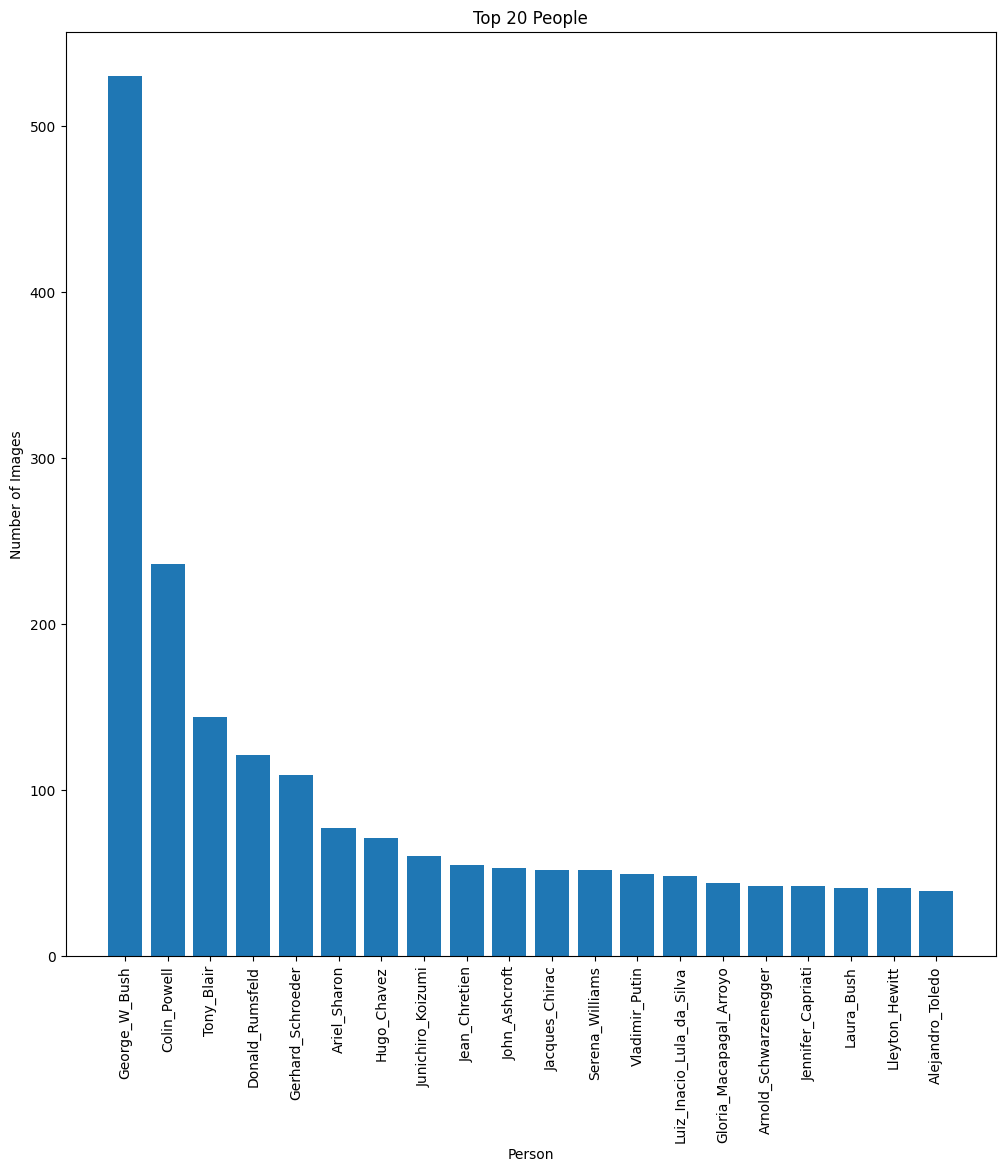

In [4]:
from collections import Counter

target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [5]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-20,86,1.50,1251,9.45
4,21-30,25,0.43,613,4.63
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Plot Some Images

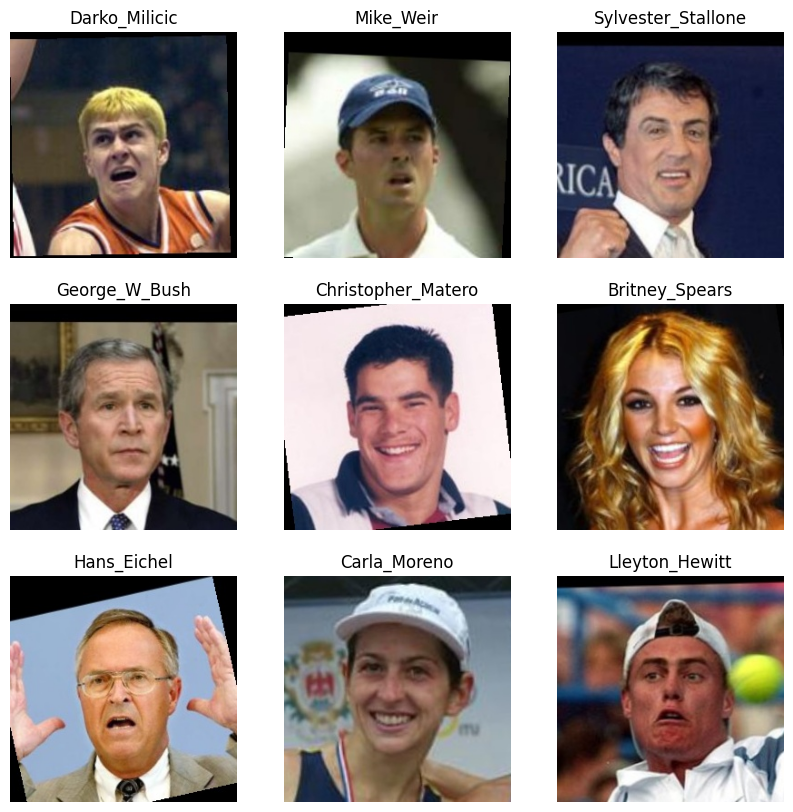

In [6]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

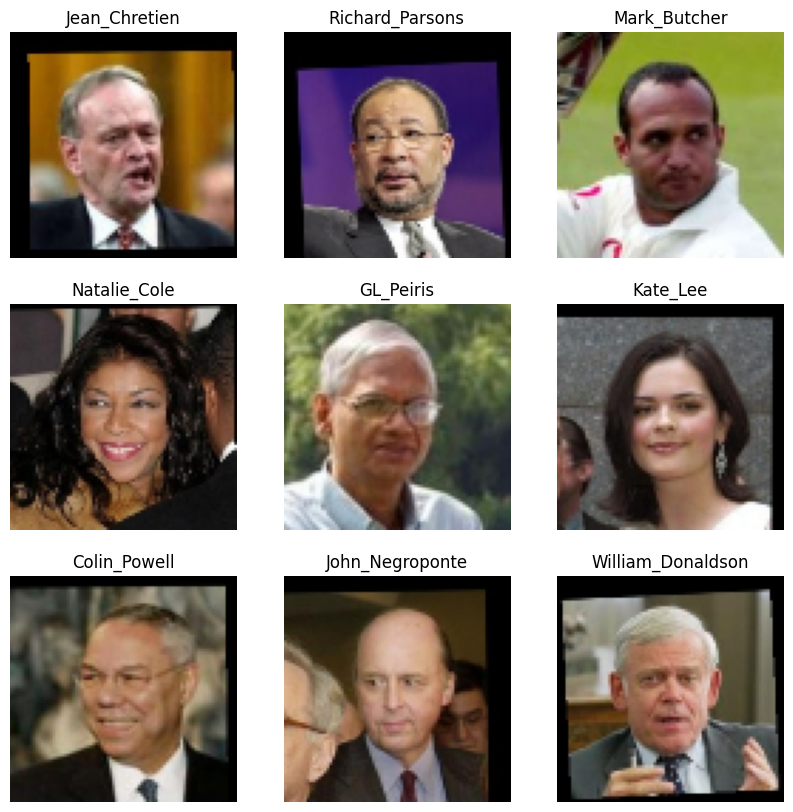

In [7]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))


display_random_images(resized_images, dataset['target'], 3, 3)

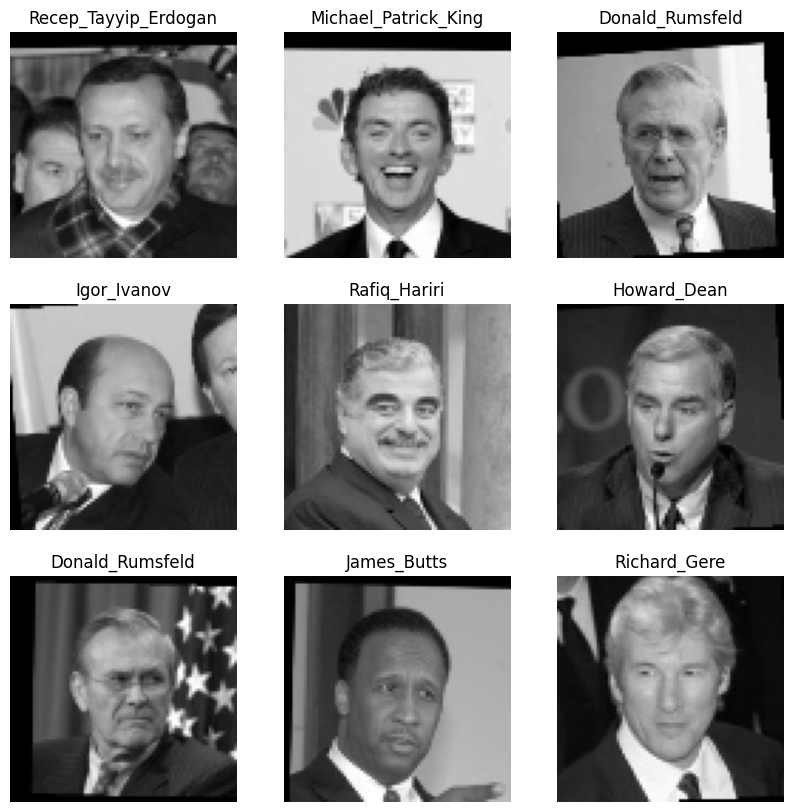

In [8]:
# Gray scale

def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

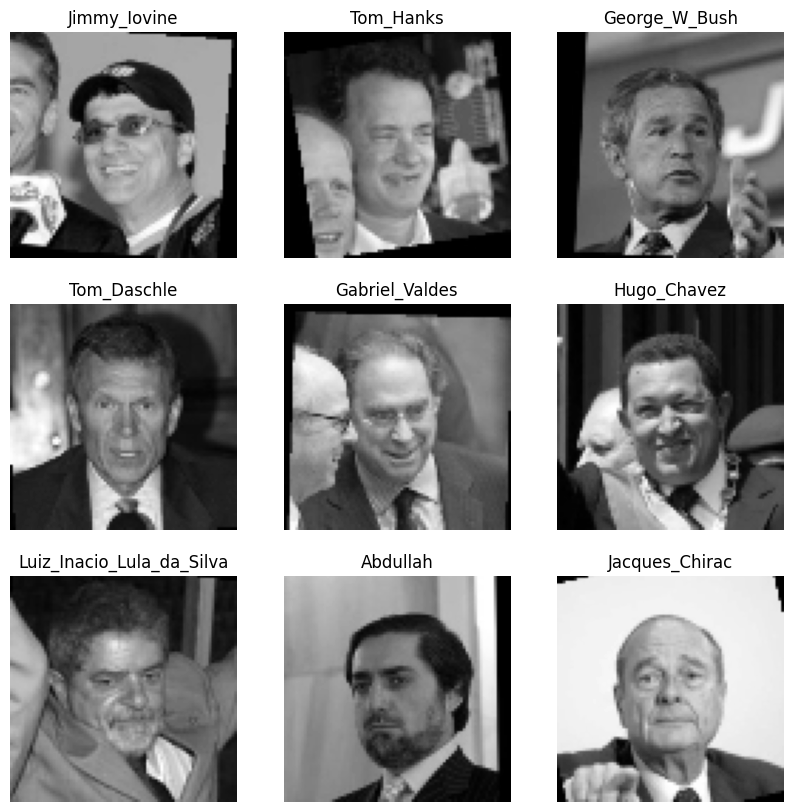

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 80 * 80)).reshape(-1, 80, 80)

display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

### Feature Extractions

#### Filter Dataset

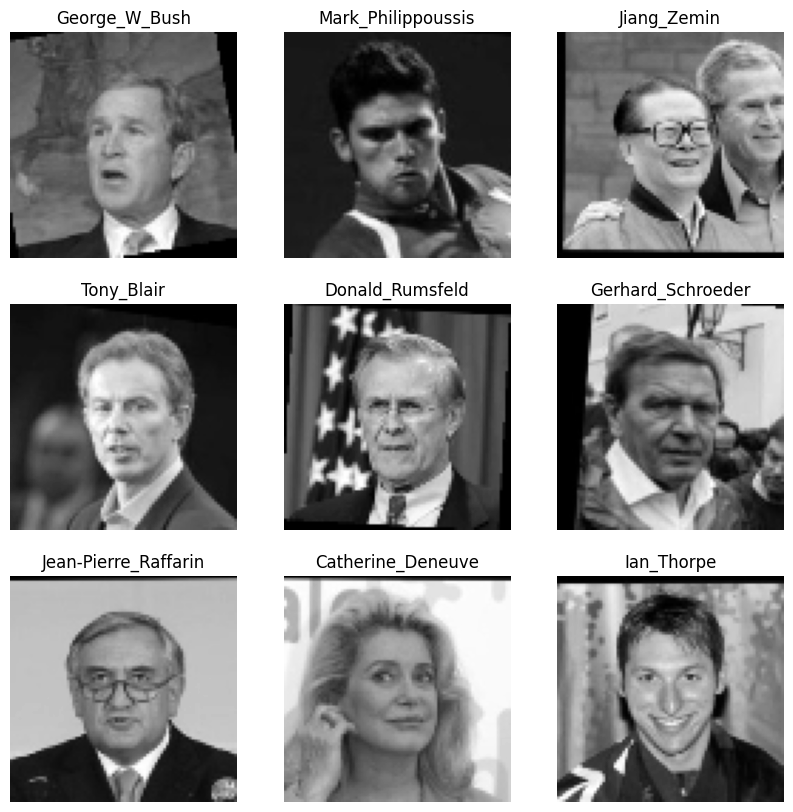

In [10]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=5)

display_random_images(filtered_dataset['data'], filtered_dataset['target'], 3, 3, cmap='gray')

In [11]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (5985, 80, 80)


#### Principal Component Analysis (PCA):

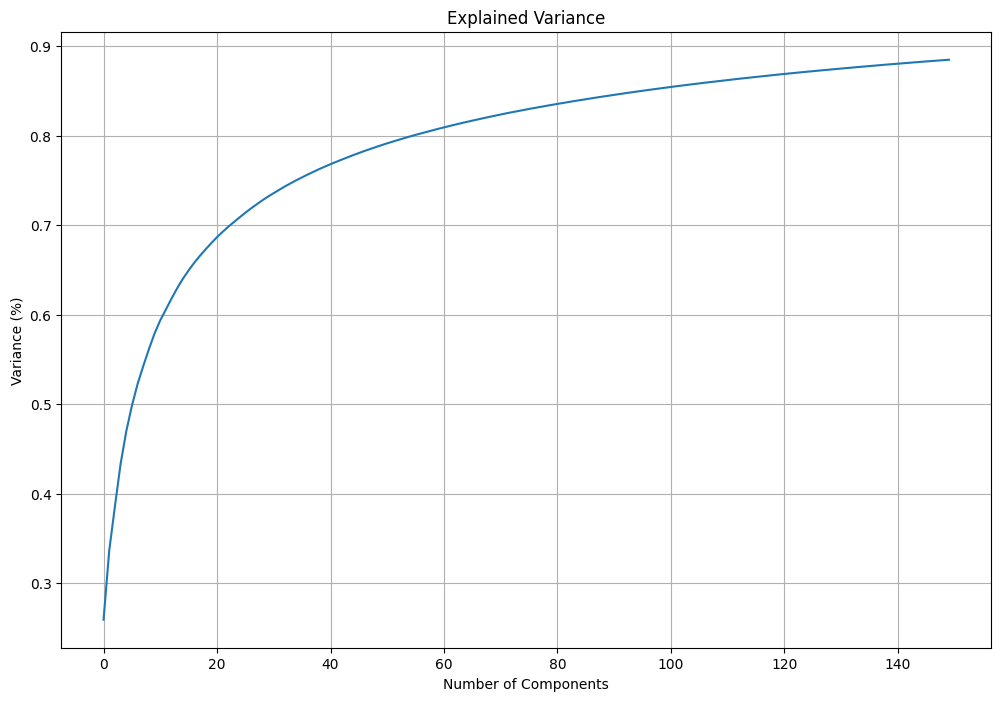

In [12]:
from sklearn.decomposition import PCA

X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(-1, 80 * 80)

pca = PCA(n_components=150, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)
# plot the explained variance ratio
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [13]:
# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Create an SVM classifier with the chosen parameters
clf = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)

# Train the model on the training set
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_pca = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_pca )
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.2606516290726817

Classification Report:
                                  precision    recall  f1-score   support

                   Abdullah_Gul       0.25      0.25      0.25         4
                   Adrien_Brody       0.50      0.33      0.40         3
                  Ahmed_Chalabi       0.00      0.00      0.00         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         2
                    Al_Sharpton       0.00      0.00      0.00         1
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         1
                   Albert_Costa       1.00      1.00      1.00         1
               Alejandro_Toledo       0.33      0.75      0.46         8
                      Ali_Naimi       0.00      0.00      0.00         2
                  Allyson_Felix       0.00      0.00      0.00       

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### Local Binary Patterns (LBP):

In [14]:
from skimage import feature
import numpy as np

def extract_lbp_features(images, image_shape):
    lbp_features = []

    for image in images:
        # Reshape the flattened image to 2D
        image = image.reshape(image_shape)

        # Compute LBP features
        lbp = feature.local_binary_pattern(image, P=8, R=1, method="uniform")

        # Flatten the LBP features and append to the list
        lbp_features.append(lbp.flatten())

    return np.array(lbp_features)

# Assuming X is a list of flattened images and image_shape is the shape of each image
image_shape = (80,80)  # Replace with the actual dimensions of your images

X = filtered_dataset['data']
y = filtered_dataset['target']

lbp_X = extract_lbp_features(X, image_shape)


C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [15]:
# Split the LBP features into training and testing sets
X_train_lbp, X_test_lbp,y_train, y_test = train_test_split(lbp_X, y, test_size=0.2, random_state=42, stratify=y)

# Use SVM classifier on LBP features
clf_lbp = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_lbp.fit(X_train_lbp, y_train)

# Predict on the LBP test set
y_pred_lbp = clf_lbp.predict(X_test_lbp)
accuracy_lbp = accuracy_score(y_test, y_pred_lbp)
# Print the accuracy and classification report for LBP
print("\nAccuracy (LBP):",accuracy_lbp )
print("\nClassification Report (LBP):\n", classification_report(y_test, y_pred_lbp))


Accuracy (LBP): 0.0885547201336675

Classification Report (LBP):
                                  precision    recall  f1-score   support

                   Abdullah_Gul       0.00      0.00      0.00         4
                   Adrien_Brody       0.00      0.00      0.00         3
                  Ahmed_Chalabi       0.00      0.00      0.00         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         2
                    Al_Sharpton       0.00      0.00      0.00         1
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         1
                   Albert_Costa       0.00      0.00      0.00         1
               Alejandro_Toledo       0.00      0.00      0.00         8
                      Ali_Naimi       0.00      0.00      0.00         2
                  Allyson_Felix       0.00      0.00    

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Linear Discriminant Analysis (LDA):

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = filtered_dataset['data']
y = filtered_dataset['target']

# Reshape each image to a 1D vector
X_flattened = X.reshape(X.shape[0], -1)

In [17]:
# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42, stratify=y)

# Use LDA for dimensionality reduction
lda = LDA(n_components=2)  # You can adjust the number of components as needed
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Use SVM classifier
clf_lda = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)

clf_lda.fit(X_train_lda, y_train)

y_pred = clf_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred)
# Print the accuracy
print("Accuracy:", accuracy_lda)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.004177109440267335

Classification Report:
                                  precision    recall  f1-score   support

                   Abdullah_Gul       0.00      0.00      0.00         4
                   Adrien_Brody       0.00      0.00      0.00         3
                  Ahmed_Chalabi       0.00      0.00      0.00         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         2
                    Al_Sharpton       0.00      0.00      0.00         1
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         1
                   Albert_Costa       0.00      0.00      0.00         1
               Alejandro_Toledo       0.00      0.00      0.00         8
                      Ali_Naimi       0.00      0.00      0.00         2
                  Allyson_Felix       0.00      0.00      0.00     

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Discrete Cosine Transform (DCT):

##### DCT with SVM

In [18]:
from scipy.fftpack import dct

# Function to extract DCT features
def extract_dct_features(images, block_size=8):
    dct_features = []

    for image in images:
        # Check if the image is grayscale (2D) or color (3D)
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)  # Add channel dimension

        # Apply 2D DCT block-wise
        m, n, channels = image.shape
        dct_coefficients = np.zeros_like(image, dtype=float)

        for i in range(0, m, block_size):
            for j in range(0, n, block_size):
                # Extract block from the image
                block = image[i:i+block_size, j:j+block_size, 0]  # Assuming single channel (grayscale)
                
                # Apply 2D DCT to the block
                dct_block = dct(dct(block, axis=0), axis=1)

                # Store the DCT coefficients in the corresponding block of the result array
                dct_coefficients[i:i+block_size, j:j+block_size, 0] = dct_block

        # Flatten the DCT coefficients and append to the list
        dct_features.append(dct_coefficients.flatten())

    return np.array(dct_features)


In [19]:
# Assuming 'X' is your filtered dataset
X = filtered_dataset['data']
y = filtered_dataset['target']

# Assuming your images are of size (80, 80)
block_size = 8  # You may adjust the block size based on your requirements
dct_X_original = extract_dct_features(X, block_size=block_size)

# Split the DCT features into training and testing sets
X_train_dct, X_test_dct, _, _ = train_test_split(dct_X_original, y, test_size=0.2, random_state=42, stratify=y)

# Use SVM classifier on DCT features
clf_dct = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_dct.fit(X_train_dct, y_train)

# Predict on the DCT test set
y_pred_dct = clf_dct.predict(X_test_dct)
accuracy_dct = accuracy_score(y_test, y_pred_dct)
# Print the accuracy and classification report for DCT
print("\nAccuracy (DCT):", accuracy_dct)
print("\nClassification Report (DCT):\n", classification_report(y_test, y_pred_dct))


Accuracy (DCT): 0.0885547201336675

Classification Report (DCT):
                                  precision    recall  f1-score   support

                   Abdullah_Gul       0.00      0.00      0.00         4
                   Adrien_Brody       0.00      0.00      0.00         3
                  Ahmed_Chalabi       0.00      0.00      0.00         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         2
                    Al_Sharpton       0.00      0.00      0.00         1
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         1
                   Albert_Costa       0.00      0.00      0.00         1
               Alejandro_Toledo       0.00      0.00      0.00         8
                      Ali_Naimi       0.00      0.00      0.00         2
                  Allyson_Felix       0.00      0.00    

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

##### DCT with random forest classification

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming dct_X_original is your feature matrix and y is your labels
X_train, X_test, y_train, y_test = train_test_split(dct_X_original, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Random Forest): {accuracy}")

Accuracy (Random Forest): 0.16374269005847952


#### Maximally Stable Extremal Regions (MSER)

In [21]:
# Initialize the MSER detector
mser = cv2.MSER_create()

# Function to extract MSER features
def extract_mser_features(images):
    mser_features = []

    for image in images:
        # Convert the image to grayscale if it's not already
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # Ensure the image is in the correct format (8-bit)
        if gray.dtype != np.uint8:
            gray = gray.astype(np.uint8)

        # Detect MSER regions
        regions, _ = mser.detectRegions(gray)

        # Extract features from the MSER regions (customize this based on your needs)
        mser_features.append(extract_features_from_regions(regions))

    return np.array(mser_features)

# Function to extract features from MSER regions (customize this based on your needs)
def extract_features_from_regions(regions):
    # For example, you might want to compute the number of detected regions
    return len(regions)

In [22]:

X = filtered_dataset['data']
y = filtered_dataset['target']
# Assuming X contains your preprocessed images
# Extract MSER features from your dataset

mser_X = extract_mser_features(X)
mser_X_reshaped = mser_X.reshape(-1,1)
# Assuming you have already split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mser_X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# Use SVM classifier on MSER features
clf_mser = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_mser.fit(X_train, y_train)

# Predict on the MSER test set
y_pred_mser = clf_mser.predict(X_test)
accuracy_mser = accuracy_score(y_test, y_pred_mser)

# Print the accuracy and classification report for MSER
print("\nAccuracy (MSER):",accuracy_mser )
print("\nClassification Report (MSER):\n", classification_report(y_test, y_pred_mser))



Accuracy (MSER): 0.01921470342522974

Classification Report (MSER):
                                  precision    recall  f1-score   support

                   Abdullah_Gul       0.00      0.00      0.00         4
                   Adrien_Brody       0.00      0.00      0.00         3
                  Ahmed_Chalabi       0.00      0.00      0.00         1
                    Ai_Sugiyama       0.00      0.00      0.00         1
                        Al_Gore       0.00      0.00      0.00         2
                    Al_Sharpton       0.00      0.00      0.00         1
                 Alan_Greenspan       0.00      0.00      0.00         1
              Alastair_Campbell       0.00      0.00      0.00         1
                   Albert_Costa       0.00      0.00      0.00         1
               Alejandro_Toledo       0.00      0.00      0.00         8
                      Ali_Naimi       0.00      0.00      0.00         2
                  Allyson_Felix       0.00      0.00 

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Convolutional Neural Network (CNN):

In [23]:
print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


NameError: name 'X_train_cnn' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming 'X' is your filtered dataset
X = filtered_dataset['data']
y = filtered_dataset['target']

# Reshape images to the required format for CNN (assuming channels-last format)
X_reshaped = X.reshape((-1, 80, 80, 1)) # Adjust dimensions based on your actual image shape

# Split the data into training and testing sets using stratified sampling
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Assuming number of classes equals unique labels
])

X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)



NameError: name 'filtered_dataset' is not defined

### Model Training

#### PCA with SVM

In [ ]:
# SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Create an SVM classifier
clf = svm.SVC(kernel="rbf", class_weight="balanced")

# Perform 10-fold cross-validation
scores = cross_val_score(clf, X_pca, y, cv=10)


# print cross-validation scores with %
print("Cross-validation scores: {}".format(scores * 100))
print("Average cross-validation score: {:.2f}%".format(scores.mean() * 100))

# Train the model
clf.fit(X_pca, y)

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation scores: [3.50584307 4.84140234 3.50584307 3.50584307 4.0066778  5.35117057
 5.51839465 5.51839465 3.34448161 3.51170569]
Average cross-validation score: 4.26%


SVC(class_weight='balanced')

### Save & Load Model

In [ ]:
import pickle

# if model.pkl not exists, create it
if not os.path.exists('model.pkl'):
    with open('model.pkl', 'wb') as f:
        pickle.dump(clf, f)

Predicted label: Mahmoud_Abbas
Actual label: Mahmoud_Abbas


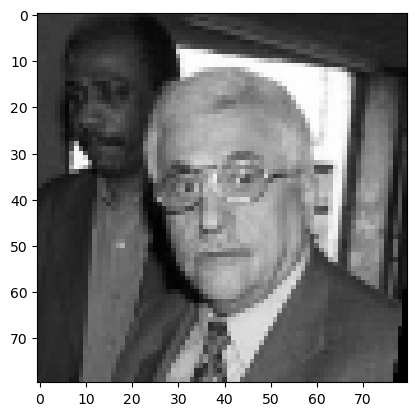

In [ ]:
model_filename = './model.pkl'

pickle.dump(clf, open(model_filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(model_filename, 'rb'))

# Test the model on a random image

index = np.random.randint(len(filtered_dataset['data']))

test_image = filtered_dataset['data'][index]

plt.imshow(test_image, cmap='gray')

test_image = test_image.reshape(1, -1)

test_image_pca = pca.transform(test_image)

pred = loaded_model.predict(test_image_pca)

print("Predicted label:", pred[0])
print("Actual label:", filtered_dataset['target'][index])

#### Test WITH REAL IMAGE

In [ ]:
test_image = cv2.imread('./Data/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0013.jpg')

test_image = resize_image([test_image], target_size=(80, 80))[0]

test_image = gray_scale([test_image])[0]

# Scale the image
test_image = scaler.transform(test_image.reshape(1, -1))

# Reduce the dimensions
test_image = pca.transform(test_image)

# Make a prediction

pred = clf.predict(test_image)[0]

print("Prediction:", pred)

Prediction: Gloria_Macapagal_Arroyo
